In [1]:
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor

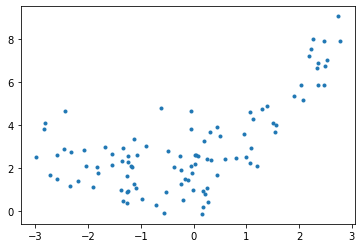

In [2]:
m = 100
x = 6 * np.random.rand(m, 1) - 3
y = 0.5 * x**2 + x + 2 + np.random.randn(m, 1)

plt.plot(x, y, '.')

In [3]:
model = Ridge(alpha = 1, solver = 'cholesky')
model.fit(x, y)

Ridge(alpha=1, solver='cholesky')

In [4]:
data = 1.5
pred = model.predict([[data]])

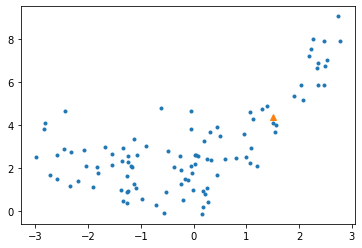

In [5]:
plt.plot(x, y, '.')
plt.plot(data, pred, '^')

In [6]:
model = SGDRegressor(penalty = 'l2')
model.fit(x, y.ravel())

pred2 = model.predict([[1.5]])

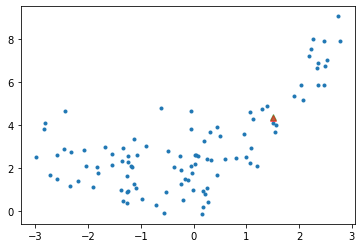

In [7]:
plt.plot(x, y, '.')
plt.plot(data, pred, '^', color='green', alpha=0.5)
plt.plot(data, pred2, '^', color='red', alpha=0.5)

In [10]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

In [11]:
iris = datasets.load_iris()
X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(np.int)

model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

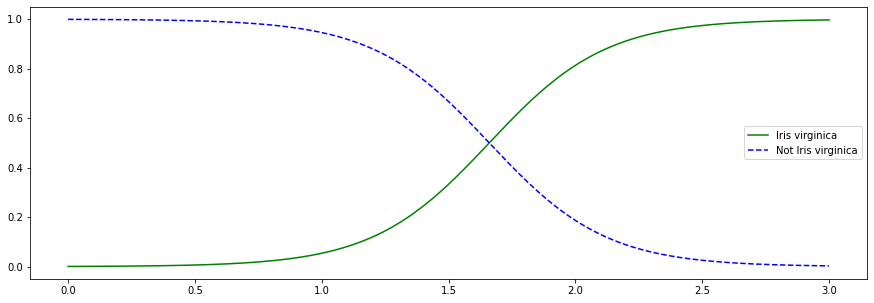

In [18]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = model.predict_proba(X_new)

plt.figure(figsize = (15, 5))
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', label='Not Iris virginica')

plt.legend()

# 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀 구현하기

1. Data Load ( Iris dataset )
2. Adding bias to the sample
3. train, valid, test data split
4. one hot encoding 
5. define softmax function
6. model training + get gradient descent
7. predict
8. adding l2 regularization
9. adding early stopping
10. visualization
11. Evaluation matrix

# 1.Load to Iris dataset 

In [76]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
iris = datasets.load_iris()

X = iris["data"][:, (2, 3)]
y = iris["target"]

# 2. Adding bias to the sample

data shape = (150, 2)

-> define bias (150, 1) and concatenate sample data

In [77]:
X = np.c_[np.ones([len(X), 1]), X]

# 3. train, valid, test data split

In [78]:
test_data_ratio = 0.2
validation_data_ratio = 0.2
total_data_length = len(X)

validation_size = int(total_data_length * validation_data_ratio)
test_size = int(total_data_length * test_data_ratio)
train_size = total_data_length - validation_size - test_size

rnd_indices = np.random.permutation(total_data_length)

X_train, y_train = X[rnd_indices[:train_size]], y[rnd_indices[:train_size]]
X_valid, y_valid = X[rnd_indices[train_size:train_size+validation_size]], y[rnd_indices[train_size:train_size+validation_size]]
X_test, y_test = X[rnd_indices[train_size+validation_size:]], y[rnd_indices[train_size+validation_size:]]

print(X_train.shape, X_valid.shape, X_test.shape)

(90, 3) (30, 3) (30, 3)


# 4. one hot encoding 

In [79]:
def onehot(labels):
    input_max = labels.max() + 1
    nums = len(labels)
    arrays = np.zeros((nums, input_max))
    arrays[np.arange(nums), labels] = 1
    
    return arrays

In [80]:
y_train = onehot(y_train)
y_valid = onehot(y_valid)
y_test = onehot(y_test)

# 5. define softmax function

In [81]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [82]:
n_inputs = X_train.shape[1] # == 3 (특성 2개와 편향)
n_outputs = y_train.shape[1]  # == 3 (3개의 붓꽃 클래스)

# 6. model training + get gradient descent

In [83]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(y_train * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - y_train
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.965806606359811
500 0.7415755655787903
1000 0.6176095039202801
1500 0.545288380295635
2000 0.4982508316955342
2500 0.4648042108157524
3000 0.43938126394871013
3500 0.41908278036928126
4000 0.4022715136237835
4500 0.3879575201735429
5000 0.37550729863142657


In [84]:
Theta

array([[ 4.11149016, -0.48488899, -2.23752859],
       [-0.81805668,  1.02785048,  0.47559546],
       [-1.41500975, -1.98033364,  0.84443967]])

# 7. predict

In [101]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

match_pred = (y_predict == np.argmax(y_valid, axis = 1))

accuracy_score = np.mean(match_pred)
accuracy_score

0.9666666666666667

# 8. adding l2 regularization

In [103]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(y_train * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - y_train
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 2.7801498072105475
500 0.5227800603910003
1000 0.5009899276377042
1500 0.49427447860170776
2000 0.4916848113396771
2500 0.4906088839197599
3000 0.4901447405068228
3500 0.4899401109731646
4000 0.4898486802945955
4500 0.4898074789987713
5000 0.48978880953988213


In [104]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

match_pred = (y_predict == np.argmax(y_valid, axis = 1))

accuracy_score = np.mean(match_pred)
accuracy_score

0.9666666666666667

# Visualization

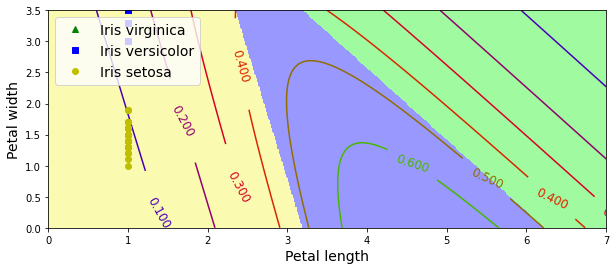

In [105]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()